<a href="https://colab.research.google.com/github/MathiLogha/Lstm/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
data = pd.read_csv(url)
print(data.head())

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [ ]:
data = data.dropna()
scaler = MinMaxScaler()
data["scaled_pm2.5"] = scaler.fit_transform(data[["pm2.5"]].values)


train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(1, x.size(0), self.hidden_size).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.01


train_X = torch.Tensor(train_data["scaled_pm2.5"].values).view(-1, 1, 1)
train_y = torch.Tensor(train_data["scaled_pm2.5"].values).view(-1, 1)


model = LSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(train_X)
    loss = criterion(outputs, train_y)

    if np.isnan(loss.item()):
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))
        break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))


model.eval()
test_X = torch.Tensor(test_data["scaled_pm2.5"].values).view(-1, 1, 1)
predicted_y = model(test_X).detach().numpy()
predicted_y = scaler.inverse_transform(predicted_y)


if np.isnan(predicted_y).any():
    print("Predicted values contain NaN")
else:
    test_y = test_data["pm2.5"].values
    rmse = np.sqrt(np.mean((predicted_y - test_y)**2))
    print("RMSE:", rmse)


Epoch [1/100], Loss: 0.0145
Epoch [11/100], Loss: 0.0072
Epoch [21/100], Loss: 0.0039
Epoch [31/100], Loss: 0.0004
Epoch [41/100], Loss: 0.0004
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0001
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
RMSE: 133.43228308158473


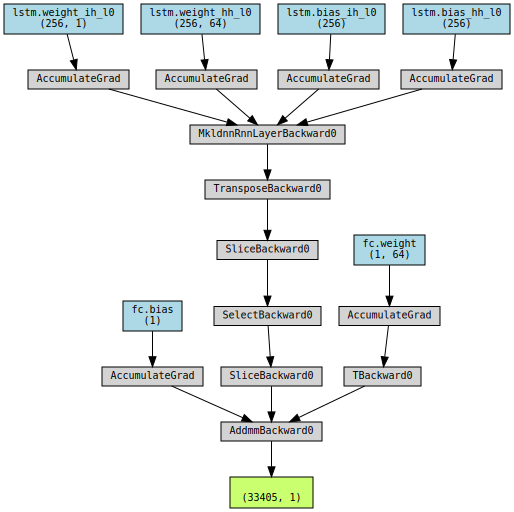

In [ ]:
from torchviz import make_dot
outputs=model(train_X)
make_dot(outputs, params=dict(model.named_parameters()))